In [1]:
#!pip install -U pandasql
#!pip install --upgrade pandas

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlalchemy
from pandasql import sqldf
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 8

### Part I: Data ETL

In [2]:
!ls

Customer.xlsx                       Promotion.xlsx
Data Analysis.ipynb                 Shipment.xlsx
Individual.xlsx                     SpecialGroup(1).xlsx
Junction_Merch_Order.xlsx           SpecialGroup.xlsx
Junction_Merchandise_Promotion.xlsx Transaction(1).xlsx
Merchandise.csv                     Transaction.xlsx
Merchandise.xlsx                    Transaction_Products.xlsx
Order.xlsx                          Transaction_Promotion.xlsx


In [3]:
order = pd.read_excel('Order.xlsx', header =0, )
transaction = pd.read_excel('Transaction.xlsx', header = 0)
transaction_products = pd.read_excel('Transaction_Products.xlsx', header = 0)
shipment = pd.read_excel('Shipment.xlsx', header = 0)
junction_merch_order= pd.read_excel('Junction_Merch_Order.xlsx', header = 0)

In [4]:
merchandise = pd.read_excel('Merchandise.xlsx', header = 0)

In [5]:
shipment.head()

,SHIP_ID,SHIPPER_ID,OID,Quantity,Price_of_goods,Ship_date,Arrival_date,Ship_to,Ship_from,Ship_cost
0,40000,45000,50000,50,375.0,2014-01-07,2014-01-10,Berkeley,Los Angeles,200
1,40001,45001,50001,100,1125.0,2014-01-14,2014-01-17,Berkeley,Las Vegas,450
2,40002,45002,50002,50,1500.0,2014-01-16,2014-01-20,Berkeley,Seattle,300
3,40003,45000,50003,100,1875.0,2014-01-20,2014-01-23,Berkeley,Los Angeles,300
4,40004,45001,50004,50,375.0,2014-01-21,2014-01-24,Berkeley,Las Vegas,400


In [6]:
order.head(5) # 2014-01-13 to 2014-02-18

,OID,EID,Order_date,Order_time,Wholesale_cost
0,50000,1013,2014-01-04,16:54:56,375.0
1,50001,1014,2014-01-13,11:40:45,1125.0
2,50002,1012,2014-01-15,15:19:40,1500.0
3,50003,1014,2014-01-17,16:59:05,1875.0
4,50004,1012,2014-01-18,14:25:46,375.0


In [7]:
#2014-01-01 to 2015-12-31
transaction.reset_index(drop = True, inplace= True)
transaction_products.reset_index(drop = True, inplace= True)
shipment.reset_index(drop = True, inplace= True)
junction_merch_order.reset_index(drop = True, inplace= True)

In [8]:
order.columns

Index(['OID', 'EID', 'Order_date', 'Order_time', 'Wholesale_cost'], dtype='object')

In [9]:
junction_merch_order.columns

Index(['SKU', 'OID'], dtype='object')

In [10]:
#!pip install pysqldf

In [11]:
transaction_products.head(1)

,TID,SKU,Quantity
0,20000,49,1


## Query 1: Most popular Items

In [12]:
pysqldf = lambda q: sqldf(q, globals())

q  = """
SELECT SKU FROM (
SELECT
 tp.SKU, SUM(tp.Quantity) AS sales
FROM
  transaction2 AS t INNER JOIN transaction_products2 AS tp
ON t.TID = tp.TID
GROUP BY SKU
ORDER BY sales DESC
)
"""
transaction2 = pd.DataFrame(transaction)
transaction_products2 = pd.DataFrame(transaction_products)
most_popular_items = pysqldf(q)

In [13]:
most_popular_items.head(10)

,SKU
0,62
1,61
2,34
3,63
4,89
5,91
6,50
7,86
8,48
9,88


In [14]:
transaction2.head(1)

,TID,EID,CID,Date,Total Cost,Time,Weekday,DIS_ID
0,20000,1000,30011,2014-01-01,12.87,09:38:12,1,90019


In [15]:
transaction_products2.head(1)

,TID,SKU,Quantity
0,20000,49,1


# Query 2: transaction history (top 1 product)

In [16]:
q2  = """
SELECT strftime('%Y-%m-%d',t.Date) AS date, tp.SKU AS SKU, SUM(tp.Quantity) AS purchase
FROM transaction2 AS t INNER JOIN transaction_products2 AS tp
ON t.TID = tp.TID 
WHERE tp.SKU IN (62)
GROUP BY t.Date, tp.SKU ;
"""
most_popular_items2 = most_popular_items
transaction2 = pd.DataFrame(transaction)
transaction_products2 = pd.DataFrame(transaction_products)
transaction_history = pysqldf(q2)

In [17]:
transaction_history.head(5)

,date,SKU,purchase
0,2014-01-03,62,1
1,2014-01-04,62,7
2,2014-01-07,62,2
3,2014-01-08,62,2
4,2014-01-09,62,1


## Query 3: shipment history (top 1 products)

In [18]:
shipment.head(1)

,SHIP_ID,SHIPPER_ID,OID,Quantity,Price_of_goods,Ship_date,Arrival_date,Ship_to,Ship_from,Ship_cost
0,40000,45000,50000,50,375.0,2014-01-07,2014-01-10,Berkeley,Los Angeles,200


In [19]:
order.head(1)

,OID,EID,Order_date,Order_time,Wholesale_cost
0,50000,1013,2014-01-04,16:54:56,375.0


In [20]:
junction_merch_order.head(1)

,SKU,OID
0,48,50000


In [21]:
q3  = """
SELECT SKU , strftime('%Y-%m-%d', Arrival_date) AS date, SUM(Quantity) AS shipment
FROM shipment2 AS s INNER JOIN junction_merch_order2 AS j 
ON s.OID =  j.OID
INNER JOIN order2 AS o
on s.OID = o.OID
WHERE j.SKU in (62)
GROUP BY Arrival_date, SKU
;
"""
#most_popular_items2 = most_popular_items
order2 = pd.DataFrame(order)
shipment2 = pd.DataFrame(shipment)
junction_merch_order2 = pd.DataFrame(junction_merch_order)
shipment_history = pysqldf(q3)

In [22]:
shipment_history

,SKU,date,shipment
0,62,2014-02-22,50


## Query 4: Create Date Range

In [23]:
date_range = pd.DataFrame({'Date' : pd.date_range('2014-01-01', '2015-12-31')})

In [24]:
date_range.head(5)

,Date
0,2014-01-01
1,2014-01-02
2,2014-01-03
3,2014-01-04
4,2014-01-05


## Query 5 Calculation

In [25]:
merchandise.head(5)

,SKU,Category,Brand_ID,Back_Room_ID,On_Floor_ID,Price,Total_inventory_quantity,Current,Essential_item
0,1,Special Event Item,6,55,40,90,14,1,0
1,2,Special Event Item,6,65,90,45,30,1,0
2,3,Special Event Item,6,35,50,120,23,1,0
3,4,Special Event Item,7,25,20,35,44,1,0
4,5,Special Event Item,7,45,30,12,34,1,0


In [26]:
merchandise.loc[merchandise['SKU'] == 62, :]

,SKU,Category,Brand_ID,Back_Room_ID,On_Floor_ID,Price,Total_inventory_quantity,Current,Essential_item
61,62,Clothing Item,1,65,60,20,47,1,1


In [38]:
q5 = """
SELECT strftime('%Y-%m-%d', x.Date) AS Date, x.purchase AS purchase, s.shipment AS shipment, x.current_inventory AS current_inventory
FROM 
(SELECT strftime('%Y-%m-%d', d.Date) AS Date, t.purchase, 47 AS current_inventory
FROM date_range2 AS d
LEFT JOIN transaction_history2 AS t ON strftime('%Y-%m-%d', d.Date) = strftime('%Y-%m-%d', t.Date)) x
LEFT JOIN shipment_history2 AS s ON strftime('%Y-%m-%d', x.Date) = strftime('%Y-%m-%d', s.Date)
"""
date_range2 = pd.DataFrame(date_range)
shipment_history2 = pd.DataFrame(shipment_history)
transaction_history2 = pd.DataFrame(transaction_history)
merchandise2 = pd.DataFrame(merchandise)
joint_table = pysqldf(q5)
joint_table.head(5)

,Date,purchase,shipment,current_inventory
0,2014-01-01,NaN,NaN,47
1,2014-01-02,NaN,NaN,47
2,2014-01-03,1.0,NaN,47
3,2014-01-04,7.0,NaN,47
4,2014-01-05,NaN,NaN,47


In [39]:
# to verify 
joint_table.loc[joint_table['Date'] == '2014-02-22',:]

,Date,purchase,shipment,current_inventory
52,2014-02-22,NaN,50.0,47


In [40]:
joint_table.loc[joint_table['Date'] == '2014-01-03',:]

,Date,purchase,shipment,current_inventory
2,2014-01-03,1.0,NaN,47


In [41]:
joint_table.shape[0]

730

In [42]:
import math

In [43]:
math.isnan(joint_table.loc[1,'purchase'])

True

In [44]:
for i in range(729, -1, -1):
    if i == 729:
        joint_table.loc[i ,'inventory_level'] = 47
    elif not math.isnan(joint_table.loc[i ,'purchase']):
        joint_table.loc[i ,'inventory_level'] = joint_table.loc[i+1 ,'inventory_level'] + joint_table.loc[i ,'purchase']
    elif not math.isnan(joint_table.loc[i ,'shipment']):
        joint_table.loc[i ,'inventory_level'] = joint_table.loc[i+1 ,'inventory_level'] - joint_table.loc[i ,'shipment']
    else:
        joint_table.loc[i ,'inventory_level'] = joint_table.loc[i+1 ,'inventory_level']
joint_table

,Date,purchase,shipment,current_inventory,inventory_level
0,2014-01-01,NaN,NaN,47,674.0
1,2014-01-02,NaN,NaN,47,674.0
2,2014-01-03,1.0,NaN,47,674.0
3,2014-01-04,7.0,NaN,47,673.0
4,2014-01-05,NaN,NaN,47,666.0
5,2014-01-06,NaN,NaN,47,666.0
6,2014-01-07,2.0,NaN,47,666.0
7,2014-01-08,2.0,NaN,47,664.0
8,2014-01-09,1.0,NaN,47,662.0
9,2014-01-10,4.0,NaN,47,661.0


In [45]:
joint_table['Date'] = pd.to_datetime(joint_table['Date'])

In [46]:
joint_table.index = joint_table['Date']
joint_table.head(5)

,Date,purchase,shipment,current_inventory,inventory_level
Date,,,,,
2014-01-01,2014-01-01,NaN,NaN,47,674.0
2014-01-02,2014-01-02,NaN,NaN,47,674.0
2014-01-03,2014-01-03,1.0,NaN,47,674.0
2014-01-04,2014-01-04,7.0,NaN,47,673.0
2014-01-05,2014-01-05,NaN,NaN,47,666.0


In [47]:
del joint_table['Date']

In [49]:
jan_to_apr_data = joint_table.loc['2014-01-01':'2014-04-01', :]

In [51]:
jan_to_apr_data['inventory_level'] = jan_to_apr_data['inventory_level'] - jan_to_apr_data['inventory_level'].min() - 5

/Users/zhonglingjiang/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [78]:
def turn_to_zero(line):
    if line < 0:
        return 0
    else:
        return line

jan_to_apr_data.loc[:,'inventory_level'].apply(turn_to_zero)

Date
2014-01-01    45.0
2014-01-02    45.0
2014-01-03    45.0
2014-01-04    44.0
2014-01-05    37.0
2014-01-06    37.0
2014-01-07    37.0
2014-01-08    35.0
2014-01-09    33.0
2014-01-10    32.0
2014-01-11    28.0
2014-01-12    28.0
2014-01-13    25.0
2014-01-14    24.0
2014-01-15    24.0
2014-01-16    22.0
2014-01-17    18.0
2014-01-18    17.0
2014-01-19    17.0
2014-01-20    16.0
2014-01-21    16.0
2014-01-22    15.0
2014-01-23    15.0
2014-01-24    15.0
2014-01-25    14.0
2014-01-26    14.0
2014-01-27    14.0
2014-01-28    14.0
2014-01-29    13.0
2014-01-30    13.0
              ... 
2014-03-03    38.0
2014-03-04    34.0
2014-03-05    34.0
2014-03-06    34.0
2014-03-07    33.0
2014-03-08    33.0
2014-03-09    30.0
2014-03-10    30.0
2014-03-11    30.0
2014-03-12    29.0
2014-03-13    28.0
2014-03-14    28.0
2014-03-15    28.0
2014-03-16    28.0
2014-03-17    28.0
2014-03-18    28.0
2014-03-19    28.0
2014-03-20    26.0
2014-03-21    26.0
2014-03-22    26.0
2014-03-23    26.0
2014-03

(-5, 50)

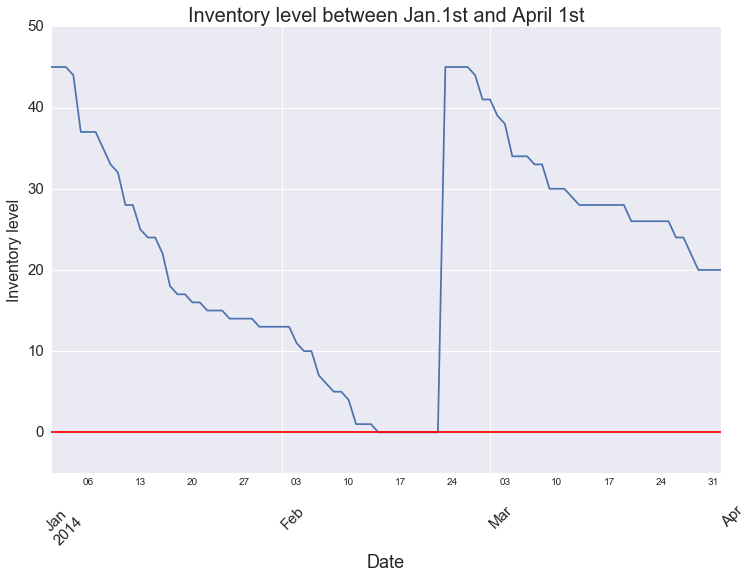

In [80]:
ts = jan_to_apr_data.loc[:,'inventory_level'].apply(turn_to_zero)
ts.plot()
plt.title('Inventory level between Jan.1st and April 1st', fontsize=20)
plt.xlabel('Date', fontsize=18)
plt.axhline(y = 0, color='r')
plt.ylabel('Inventory level', fontsize=16)
_ = plt.xticks(rotation=45, fontsize = 15)
_ = plt.yticks(fontsize = 15)
plt.ylim([-5, 50])

## Inventory Level Plot
#### From 2014-01-01 to 2015-12-31

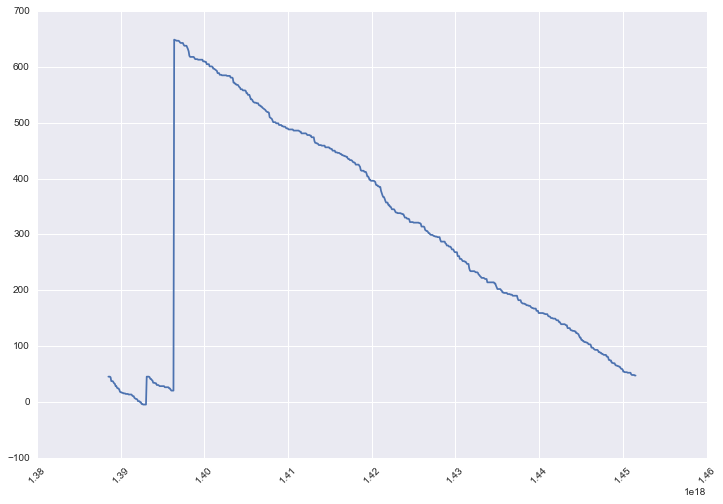

In [62]:
ts = joint_table.loc[:,['inventory_level']]
plt.plot(ts, '-', label = 'Original')
_ = plt.xticks(rotation=45)

## Model Building

In [415]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=12)
    rolstd = pd.rolling_std(timeseries, window=12)

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

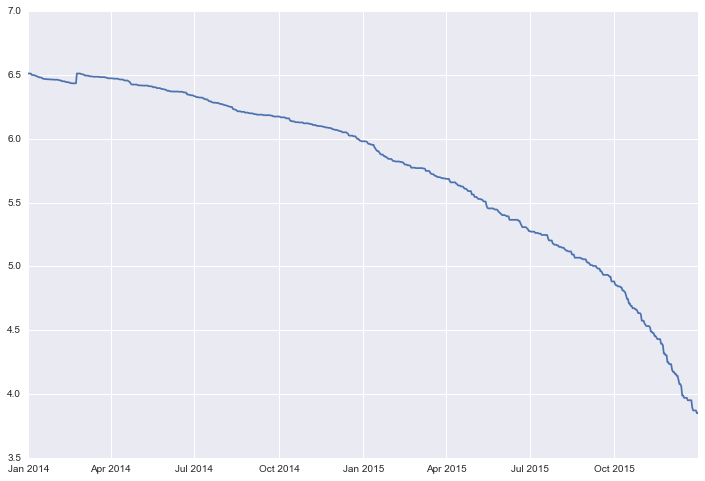

In [416]:
ts_log = np.log(ts)
plt.plot(ts_log)

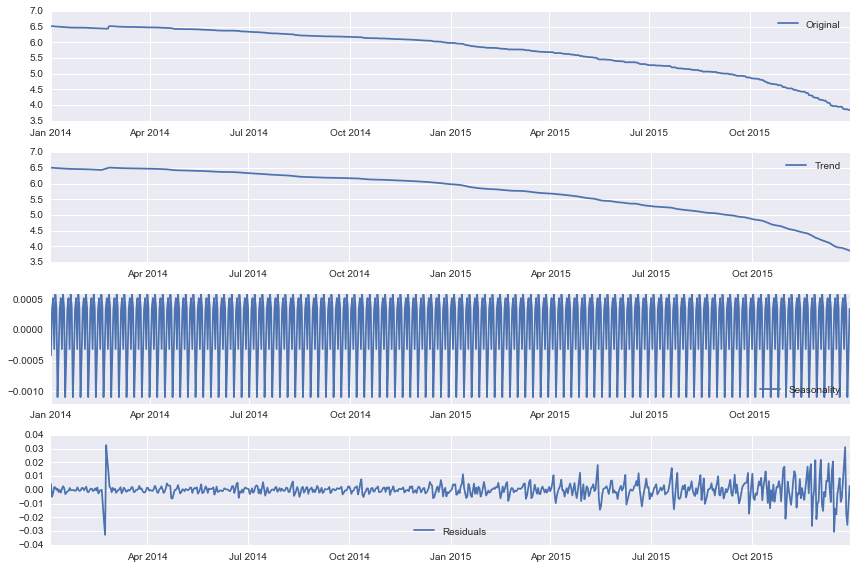

In [444]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

/Users/zhonglingjiang/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:5: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=12,center=False).mean()
/Users/zhonglingjiang/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:6: FutureWarning: pd.rolling_std is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=12,center=False).std()


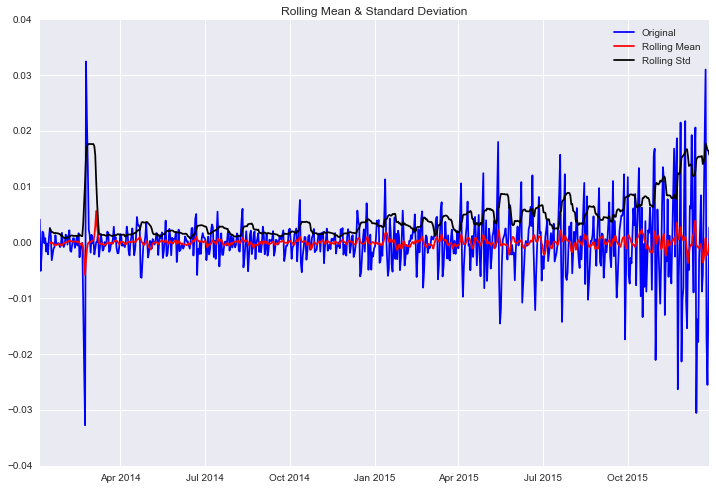

Results of Dickey-Fuller Test:


ValueError: too many values to unpack (expected 2)

In [445]:
ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)
test_stationarity(ts_log_decompose)

/Users/zhonglingjiang/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=5,center=False).mean()
  if __name__ == '__main__':


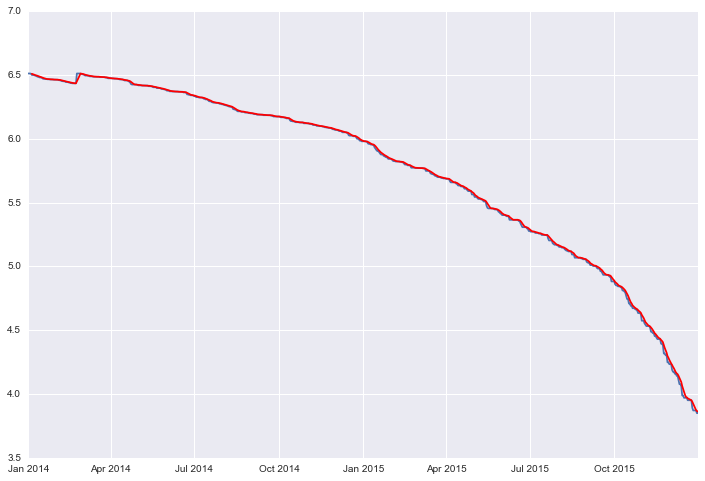

In [433]:
moving_avg = pd.rolling_mean(ts_log,5)
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

/Users/zhonglingjiang/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:5: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=12,center=False).mean()
/Users/zhonglingjiang/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:6: FutureWarning: pd.rolling_std is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=12,center=False).std()


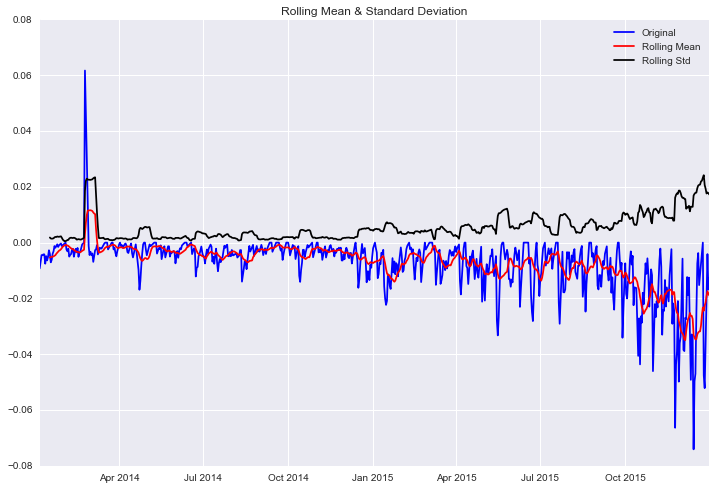

Results of Dickey-Fuller Test:


ValueError: too many values to unpack (expected 2)

In [434]:
ts_log_moving_avg_diff = ts_log - moving_avg
ts_log_moving_avg_diff.dropna(inplace=True)
test_stationarity(ts_log_moving_avg_diff)

/Users/zhonglingjiang/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: pd.ewm_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.ewm(ignore_na=False,adjust=True,min_periods=0,halflife=3).mean()
  if __name__ == '__main__':
/Users/zhonglingjiang/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:5: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=12,center=False).mean()
/Users/zhonglingjiang/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:6: FutureWarning: pd.rolling_std is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=12,center=False).std()


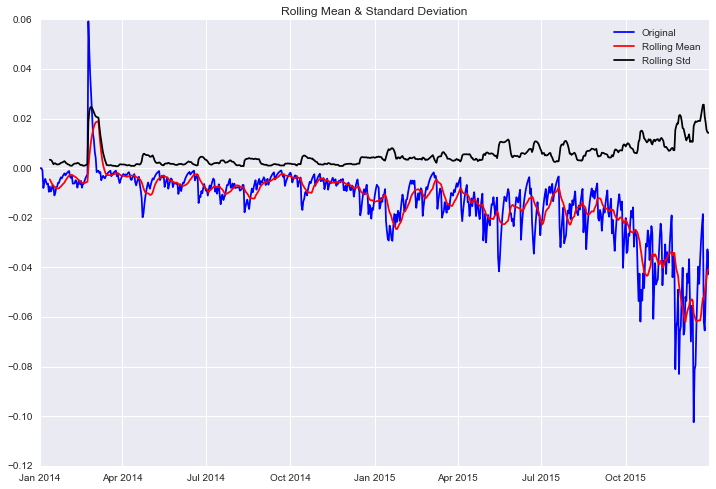

Results of Dickey-Fuller Test:


ValueError: too many values to unpack (expected 2)

In [442]:
expwighted_avg = pd.ewma(ts_log, halflife= 3)
ts_log_ewma_diff = ts_log - expwighted_avg
test_stationarity(ts_log_ewma_diff)

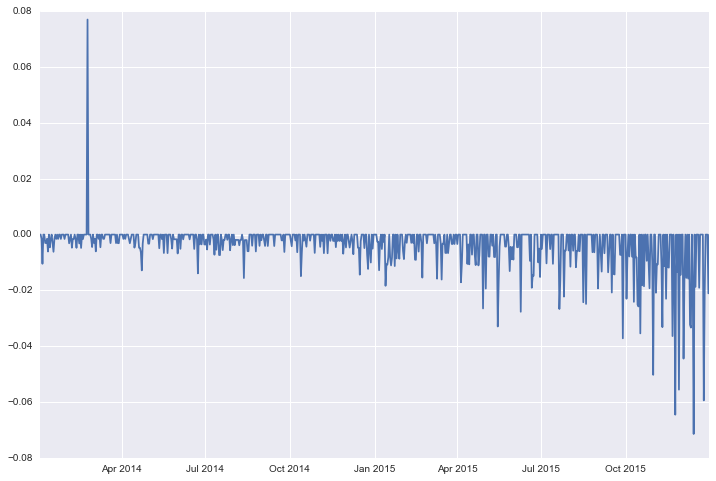

In [427]:
ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff)

In [446]:
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf

In [447]:
lag_acf = acf(ts_log_diff, nlags=20)
lag_pacf = pacf(ts_log_diff, nlags=20, method='ols')

/Users/zhonglingjiang/anaconda/lib/python3.5/site-packages/numpy/linalg/linalg.py:1574: RuntimeWarning: invalid value encountered in greater
  return (S > tol).sum(axis=-1)


LinAlgError: SVD did not converge

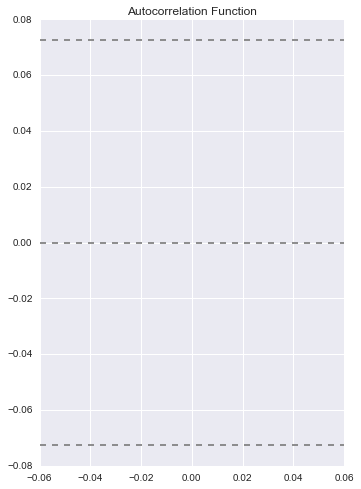

In [448]:
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

NameError: name 'lag_pacf' is not defined

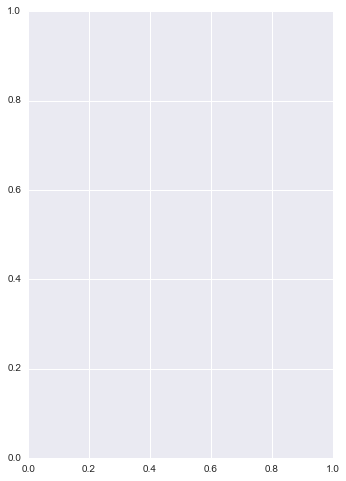

In [449]:
#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

In [458]:
ts_log

,inventory_level
Date,
2014-01-01,6.513230
2014-01-02,6.513230
2014-01-03,6.513230
2014-01-04,6.511745
2014-01-05,6.501290
2014-01-06,6.501290
2014-01-07,6.501290
2014-01-08,6.498282
2014-01-09,6.495266


In [450]:
from statsmodels.tsa.arima_model import ARIMA

/Users/zhonglingjiang/anaconda/lib/python3.5/site-packages/statsmodels/base/model.py:473: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


ValueError: Cannot add integral value to Timestamp without freq.

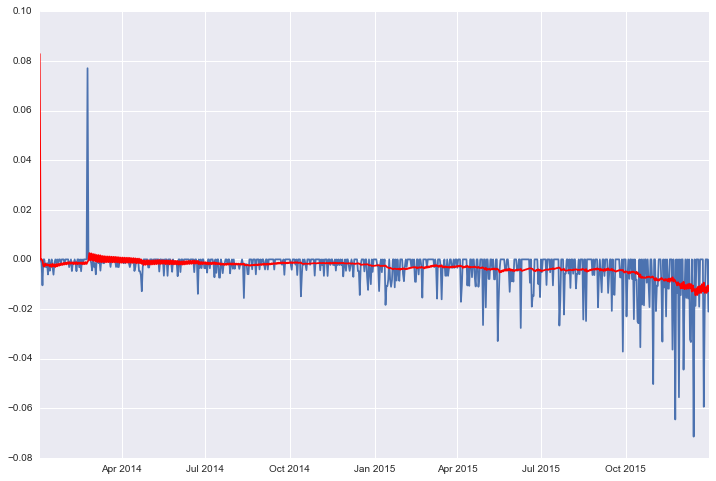

In [459]:
model = ARIMA(ts_log, order=(2, 1, 2))  
results_ARIMA = model.fit(disp=5)  
plt.plot(ts_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_log_diff)**2))

In [453]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print (predictions_ARIMA_diff.head())

Date
2014-01-02    0.082835
2014-01-03    0.000002
2014-01-04    0.000001
2014-01-05   -0.000441
2014-01-06   -0.002646
dtype: float64


ValueError: Cannot add integral value to Timestamp without freq.

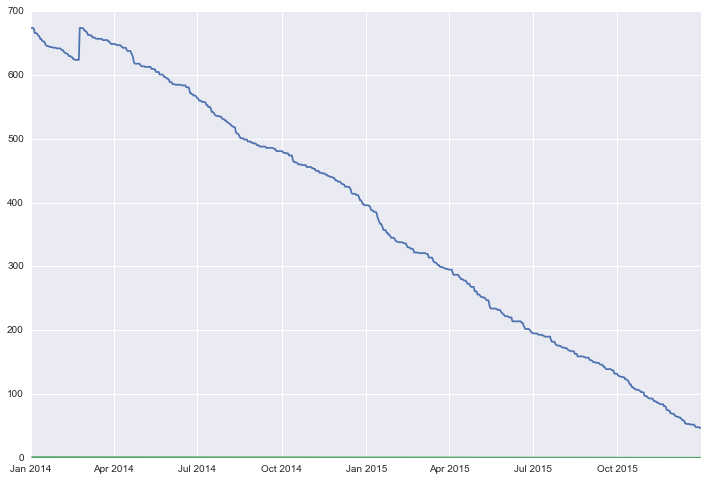

In [455]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_log = pd.Series(ts_log.ix[0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(ts)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-ts)**2)/len(ts)))